# Hire-PAT fragment analyzer data analysis
It reads `fsa` files generated from ABI fragment analyzer for High-resolution Poly(A)-tail Assay (Hire-PAT)

In [1]:
# Built-in
from collections import OrderedDict
from pathlib import Path
import pickle

# Third-party
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy.stats import binned_statistic
from ipywidgets import interact

import seaborn as sns
import numpy as np

# Local
from polya.utils import FSAAnalyzer, smooth
from polya.plot import sequential_palette, custom_cmap

styles = ['../polya.mplstyle']

In [2]:
work = "190729-1"

In [3]:
%%html
<style>
table {float:left}
</style>

### Sample descriptions
| Work (date) | Note | Figure |
| ---- | ----- | ---- |
| 190729-1 | TOP reporter 20 m tracing | Fig. 1e |
| 191217-2 | TOP reporter Decay factor KD 40 m tracing | Fig. S1b |
| 210209 | TOP reporter LARP1 KD and 30m tracing | Figs. 3a, S3d |
| 210321 | Non-TOP reporter LARP1 KD and 30m tracing | Figs. 3b, S3d |
| 210322 | Endogenous mRNAs steady-state poly(A) length after LARP1 KD (siLARP1 #2) | Fig. S3e |

In [4]:
datadir = Path("../data/hire-pat")
smptblpath = datadir/work/"samples.txt"
smptbl = pd.read_csv(smptblpath, sep='\t', comment='#')
fsafpaths = [datadir/work/fname for fname in smptbl['Filename']]
smptbl

,Sample,Filename,Cell,Gene,Group,Baseline,Data_lane,Control_lane,Control_set
0,0 m,T11-0m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
1,20 m,T11-20m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
2,40 m,T11-40m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
3,60 m,T11-60m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
4,80 m,T11-80m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
5,100 m,T11-100m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
6,120 m,T11-120m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
7,140 m,T11-140m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
8,160 m,T11-160m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz
9,180 m,T11-180m.fsa,T11,5TOPwt-TRICK,TOP,153,1,105,genescan500liz


#### Visualise raw fluorescence signals

GeneScanLIZ500 size markers (bp)  
35, 50, 75, 100, 139, 150, 160, 200, 250, 300, 340, 350, 400, 450, 490, 500

typically, data_lane = 1 and marker_lane = 4 or 105

In [5]:
# Load data for every fsa file
fsas = OrderedDict()
for idx, fsafpath in zip(smptbl.index, fsafpaths):
    lanes = smptbl.iloc[idx][['Data_lane', 'Control_lane']]
    fsa = FSAAnalyzer(fsafpath, marker_lane=lanes[1])
    
    for lane in lanes:
        fsa.load(lane)
        fsa.get_marker_peaks(height_filter_tolerance_factor=0.5)
        
    fsas[idx] = fsa


In [6]:
# Visualize raw signal intensity by lane for sanity check
# Also, find and show peak positions for the marker lane

lanes = [1,105]
xlim= 800,8000
ylim= 0,2000

def show_intensity_by_lane(lane, c, force):
    global fsafpaths, xlim, ylim
    fig, axes = plt.subplots(len(fsafpaths), 1, figsize=(8,len(fsafpaths)*1), sharex=True)
    plt.subplots_adjust(hspace=0)
    for i, fsa in fsas.items():
        ax = axes.ravel()[i]
        smp = smptbl.iloc[i,0]
        
        y = fsa.data[lane]
        x = np.arange(len(y))
        
        ax.plot(x, y, c=c)
        
        if lane == fsa.marker_lane:
            for x in fsa.get_marker_peaks(force=force, height_filter_tolerance_factor=0.5):
                ax.axvline(x, color="r", ls='--', alpha=0.5)
        
        ax.text(0.99, 0.05, s=f"fidx:{i}, {smp}", transform=ax.transAxes, ha='right')
        
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim) 
        
    plt.show()
    return
# show_intensity_by_lane(lane, xlim=(500,1500), c='gray')
interact(show_intensity_by_lane, lane=lanes[::-1], c='gray', force=True)

interactive(children=(Dropdown(description='lane', options=(105, 1), value=105), Text(value='gray', descriptio…

<function __main__.show_intensity_by_lane(lane, c, force)>

### Manually correct the marker peak positions (optional)

In [7]:
def show_signals_with_marker_peaks(fsa, marker_peaks, lane=4, xlim=None, ylim=None):
    fig, ax = plt.subplots(figsize=(5,1))
    y = fsa.data[lane]
    x = np.arange(len(y))
    ax.plot(x, y)
    
    for x in marker_peaks:
        ax.axvline(x, color="r", ls='--', alpha=0.5)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.show()
    
    print(marker_peaks)
    return

In [8]:
fidx = 17
fsa = fsas[fidx]
# marker_peaks = fsa.get_marker_peaks(force=True, height_filter_tolerance_factor=0.5)
show_signals_with_marker_peaks(fsa, fsa.marker_peaks, xlim=xlim, ylim=ylim)

KeyError: 17

In [ ]:
fixes = {
    "210321": {
        17: [[3700],[]],
    }
}

In [ ]:
fix = True

fidx = 17
fsa = fsas[fidx]

to_add = fixes[work][fidx][0]
to_remove = fixes[work][fidx][1]


fsa.add_marker_peaks(to_add)
fsa.remove_marker_peaks(to_remove)
    
show_signals_with_marker_peaks(fsa, fsa.marker_peaks, xlim=xlim, ylim=ylim)
    
if fix is False:
    fsa.remove_marker_peaks(to_add)
    fsa.add_marker_peaks(to_remove)



### Plotting the results

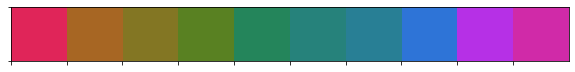

In [51]:
## Color settings

color_setting = "20m_time_course"

if color_setting == "20m_time_course":
    palette = sns.husl_palette(len(smptbl), l=0.5)
#     palette = sns.color_palette("inferno_r", len(smptbl))
#     palette = sns.color_palette("hls", 10)
    sns.palplot(palette)
    plt.show()
    
elif color_setting == "kd_time_course":

    color_graduation = True
    color_grad_pads = (2,0)
    include_mock = False

    if include_mock is False:
        smptbl = smptbl[smptbl['Sample'] != 'Mock']

    # colors by group
    colors = { 
        'mock': '#000000',
        'Mock': '#000000',
        'siNC': '#222222',

        'LARP1': '#8C000F',
        'siLARP1': '#8C000F',
        'siLARP1-3': '#8C000F',
        'siLARP1-SM': '#8C000F',

        'LARP4': '#93C01F',
        'siLARP4_4B': '#0A481E',

        'siDecay': '#6A008B',    
    }

    palettes = dict()
    for (gene, group), gr in smptbl.groupby(['Gene','Group']):
        if color_graduation is True:
            n_colors = len(gr)
            palette = sequential_palette(colors.get(group, 'black'), n_colors + np.sum(color_grad_pads))[color_grad_pads[0]: color_grad_pads[0] + n_colors]

        else:
            palette = [colors[smp] for smp in gr.loc[:,'Sample']]

        if include_mock is True:
            palette = [[0,0,0]] + palette[1:]

        palettes[(gene,group)] = palette

        sns.palplot(palette)
        print( gene, group )
        plt.show()

Plot individually

../plots/hire-pat_190729-1-T11-5TOPwt-TRICK-TOP_mini.pdf


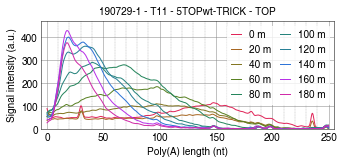

In [52]:
# Configurations
savefig = True
savepkl = False
normed = False
rescale_intensity = None
display_pAmode = False
figsize = 10.5, 4
# figsize = 9, 3.4
# figsize = 7.2, 2.8

xmin, xmax = 0, 250 # a range of poly(A) tail length
smoothing_window_len = 60

minifig = True

if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

with plt.style.context(styles):
    groups = smptbl.groupby(['Gene', 'Cell', 'Group'])
    for (gene, cell, group), gr in groups:
        fig, ax = plt.subplots(figsize=figsize)
        pAmodes = list()
        global_ymax = None
        
        for ci, (idx, entry) in enumerate(gr.iterrows()):
            fsa = fsas[idx]
            size, intensity = fsa.get(entry['Data_lane'])
            size -= entry['Baseline'] # exclude the mRNA body size
            target_range = (xmin < size) * (size < xmax)
            
            x = size[target_range]
            
            y = smooth(intensity[target_range], window_len=smoothing_window_len)
            y += np.abs(y.min()) # correct the intensity baseline
            
            if rescale_intensity is not None: y = np.interp( y, (y.min(), y.max()), rescale_intensity ) 
            if normed is True: y = y / y.sum() * 100
                
            if global_ymax is None: global_ymax = y.max()
            elif global_ymax < y.max(): global_ymax = y.max()
                
            # additional touch for DMSO vs. Torin 1 comparison
            smp = entry['Sample']
            ls = 'dotted' if smp.lower() == 'mock' else '-'
                
            if color_setting == "20m_time_course":
                color = palette[ci]
            else:
                color = palettes[(gene,group)][ci]
                
            ax.plot(x, y, color=color, label=smp, ls=ls, alpha=1)
            
            if display_pAmode is True:
                pAmode = x[np.argmax(y)]
                ax.text(x=pAmode, y=y.max(), s="*", ha="center", color=palettes[(gene,group)][ci], 
                        fontsize="xx-large", fontweight="bold", alpha=1)
            
            if savepkl is True:
                outpklpath = datadir/work/entry["Filename"].replace('.fsa','.pkl')
                pickle.dump(tuple([x,y]), open(outpklpath, 'wb'))
            
        # Grid and axes
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(1)) 
        ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
        ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
        ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
        ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
        ax.set_xlim(xmin-5,xmax+5)
        ax.set_ylim([0,global_ymax*1.1])
#         ax.set_ylim([0, 0.29])
        
        # Texts and labels
        ax.set_title("{} - {} - {} - {}".format(work, cell, gene, group), fontsize='medium')
        xlabel = "Poly(A) length (nt)"
        ylabel = "Normalized signal (%)" if normed is True else "Signal intensity (a.u.)"
        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
        ax.legend(loc="upper right", handlelength=1.0, ncol=2, columnspacing=0.8, fontsize='medium')
        
        fname_adduct = ""
        if savefig is True:
            if normed: fname_adduct += "_normed"
            if minifig is True: fname_adduct += "_mini"
            outfigpath = "../plots/hire-pat_{}-{}-{}-{}{}.pdf".format(work, cell, gene, group, fname_adduct)
            plt.savefig(outfigpath, dpi=300, bbox_inches="tight")
            print(outfigpath)
        plt.show()


/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


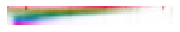

In [53]:
savefig = True

nbins = 90
fig_width=6.1

minifig = True
if minifig is True: 
    styles.append("../mini.mplstyle")
    fig_width /= 2

with plt.style.context(styles):
    groups = smptbl.groupby(['Gene', 'Cell', 'Group'])
    for (gene, cell, group), gr in groups:
        num_samples = len(gr)
        fig, axes = plt.subplots(num_samples, 1, 
                                 gridspec_kw=dict(wspace=0, hspace=0),
                                 figsize=(fig_width, fig_width/nbins * num_samples))
        
        for ci, (idx, entry) in enumerate(gr.iterrows()):
            fsa = fsas[idx]
            size, intensity = fsa.get(entry['Data_lane'])
            size -= entry['Baseline'] # exclude the mRNA body size
            target_range = (xmin < size) * (size < xmax)
            
            x = size[target_range]
            y = smooth(intensity[target_range], window_len=smoothing_window_len)
            y += np.abs(y.min()) # correct the intensity baseline
            
            if color_setting == "20m_time_course":
                color = palette[ci]
                
            ax = axes[ci]
            cmap = custom_cmap(['#FFFFFF', color])
            binstat = binned_statistic(np.arange(len(y)), y, statistic='median', bins=nbins)
            ax.imshow(binstat.statistic.reshape(-1,1).T, cmap=cmap)
            ax.axis('off')
#             ax.set_xticks([])
#             ax.set_yticks([])
        
        plt.tight_layout()
        
        fname_adduct = ""
        if savefig is True:
            if minifig is True: fname_adduct += "_mini"
            fname_adduct += "_heatmap"
            outfigpath = "../plots/hire-pat_{}-{}-{}-{}{}.pdf".format(work, cell, gene, group, fname_adduct)
            
            plt.savefig(outfigpath, dpi=300, bbox_inches='tight', pad_inches=0)